In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("uber-data-analysis") \
    .getOrCreate()

In [3]:
BASE_FILE_PATH = "../Processed_Files/4months/analytical_table_coalesced.csv/"

In [4]:
# Load the CSV files into Spark DataFrames
analytical_table_df = spark.read.csv(BASE_FILE_PATH + "analytical_table.csv", header=True, inferSchema=True)

In [5]:
# Create Temporary Views for SQL Queries
analytical_table_df.createOrReplaceTempView("analytical_table")

## 1. Total Revenue:

In [6]:
# Corrected SQL Query to Use Consistent Naming
total_revenue = spark.sql("""
    SELECT SUM(total_amount) as total_revenue
    FROM analytical_table
""")
total_revenue.show()

+--------------------+
|       total_revenue|
+--------------------+
|3.3098698576002103E8|
+--------------------+



## 2. Total Trips:

In [7]:
total_trips = spark.sql("""
    SELECT COUNT(trip_id) as total_trips
    FROM analytical_table
""")
total_trips.show()

+-----------+
|total_trips|
+-----------+
|   11946616|
+-----------+



## 3. Average Fare Amount per Trip:

In [8]:
average_fare = spark.sql("""
    SELECT AVG(fare_amount) as average_fare
    FROM analytical_table
""")
average_fare.show()


+------------------+
|      average_fare|
+------------------+
|18.707458347199942|
+------------------+



## 4. Number of Trips by Payment Type:

In [9]:
trips_by_payment_type = spark.sql("""
    SELECT payment_type_description, COUNT(trip_id) as trip_count
    FROM analytical_table
    GROUP BY payment_type_description
    ORDER BY trip_count DESC
""")
trips_by_payment_type.show()


+------------------------+----------+
|payment_type_description|trip_count|
+------------------------+----------+
|             Credit card|   9762528|
|                    Cash|   1906318|
|                 Dispute|    195990|
|               No charge|     81780|
+------------------------+----------+



## 5. Revenue by Vendor:

In [10]:
revenue_by_vendor = spark.sql("""
    SELECT vendor_name, SUM(total_amount) as total_revenue
    FROM analytical_table
    GROUP BY vendor_name
    ORDER BY total_revenue DESC
""")
revenue_by_vendor.show()

+--------------------+--------------------+
|         vendor_name|       total_revenue|
+--------------------+--------------------+
|       VeriFone Inc.|2.5644589945002282E8|
|Creative Mobile T...| 7.454108631000036E7|
+--------------------+--------------------+



## 6. Trips by Hour of the Day:

In [11]:
trips_by_hour = spark.sql("""
    SELECT pick_hour, COUNT(trip_id) as trip_count
    FROM analytical_table
    GROUP BY pick_hour
    ORDER BY pick_hour
""")
trips_by_hour.show()


+---------+----------+
|pick_hour|trip_count|
+---------+----------+
|     NULL|    716102|
|        0|    303188|
|        1|    204062|
|        2|    134770|
|        3|     88072|
|        4|     55825|
|        5|     58190|
|        6|    136949|
|        7|    291411|
|        8|    411062|
|        9|    474765|
|       10|    524794|
|       11|    570449|
|       12|    620389|
|       13|    643517|
|       14|    692581|
|       15|    719356|
|       16|    717567|
|       17|    772825|
|       18|    803784|
+---------+----------+
only showing top 20 rows



## 7. Trips by Day of the Week:

In [12]:
trips_by_day_of_week = spark.sql("""
    SELECT pick_weekday, COUNT(trip_id) as trip_count
    FROM analytical_table
    GROUP BY pick_weekday
    ORDER BY trip_count DESC
""")
trips_by_day_of_week.show()


+------------+----------+
|pick_weekday|trip_count|
+------------+----------+
|         Thu|   1847574|
|         Wed|   1728266|
|         Fri|   1678644|
|         Sat|   1678579|
|         Tue|   1553056|
|         Sun|   1391695|
|         Mon|   1352700|
|        NULL|    716102|
+------------+----------+



# Visualizing the results using matplotlib

In [13]:
# Convert Spark DataFrames to Pandas for visualization
total_revenue_pd = total_revenue.toPandas()
total_trips_pd = total_trips.toPandas()
average_fare_pd = average_fare.toPandas()
trips_by_payment_type_pd = trips_by_payment_type.toPandas()
revenue_by_vendor_pd = revenue_by_vendor.toPandas()
trips_by_hour_pd = trips_by_hour.toPandas()
trips_by_day_of_week_pd = trips_by_day_of_week.toPandas()

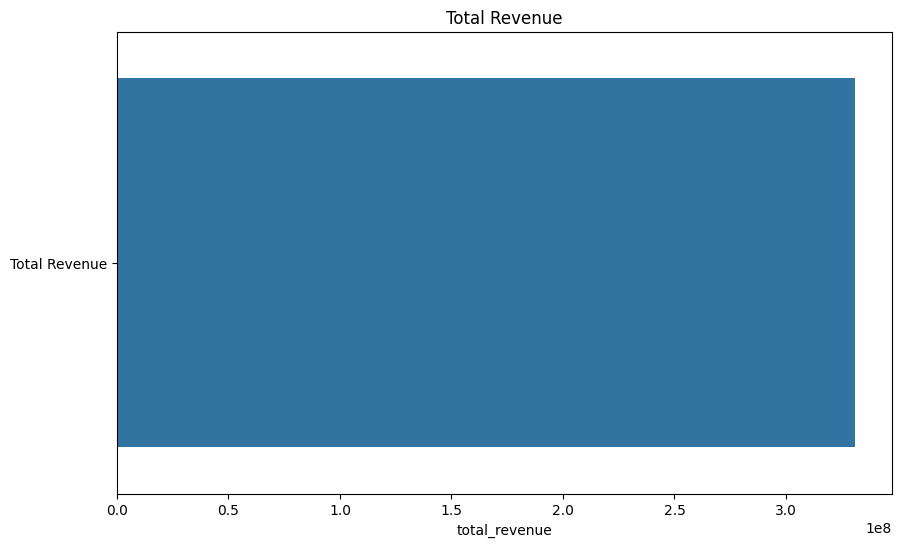

In [14]:
# Total Revenue
plt.figure(figsize=(10, 6))
sns.barplot(x="total_revenue", y=["Total Revenue"], data=total_revenue_pd)
plt.title("Total Revenue")
plt.show()

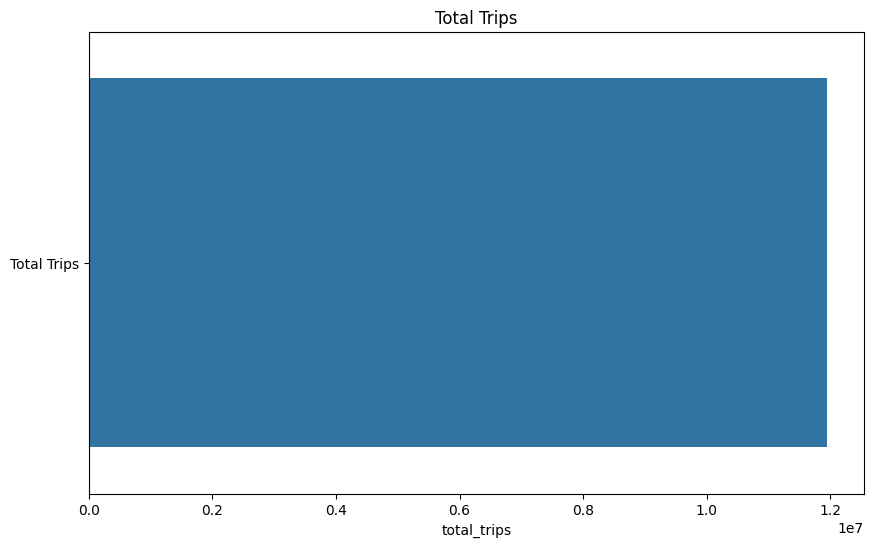

In [15]:
# Total Trips
plt.figure(figsize=(10, 6))
sns.barplot(x="total_trips", y=["Total Trips"], data=total_trips_pd)
plt.title("Total Trips")
plt.show()

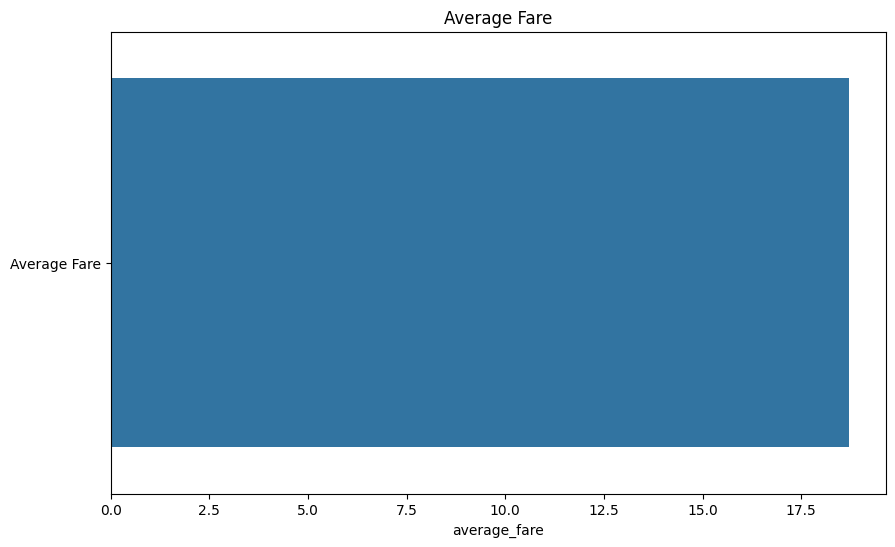

In [16]:
# Average Fare
plt.figure(figsize=(10, 6))
sns.barplot(x="average_fare", y=["Average Fare"], data=average_fare_pd)
plt.title("Average Fare")
plt.show()

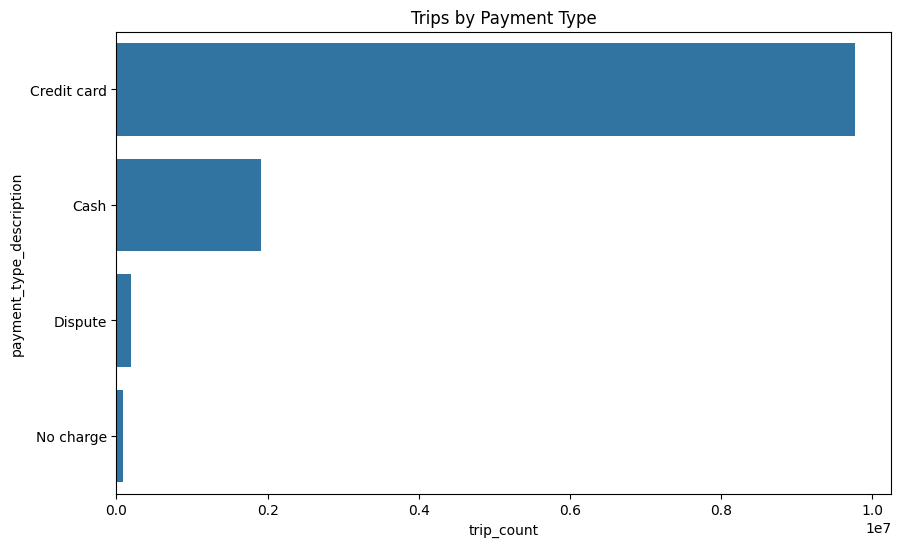

In [17]:
# Trips by Payment Type
plt.figure(figsize=(10, 6))
sns.barplot(x="trip_count", y="payment_type_description", data=trips_by_payment_type_pd)
plt.title("Trips by Payment Type")
plt.show()

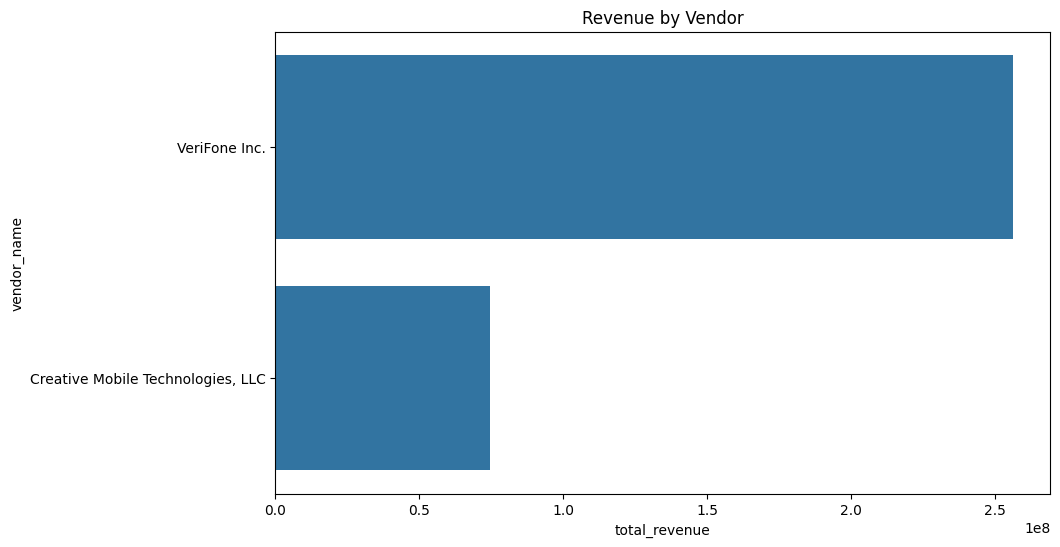

In [18]:
# Revenue by Vendor
plt.figure(figsize=(10, 6))
sns.barplot(x="total_revenue", y="vendor_name", data=revenue_by_vendor_pd)
plt.title("Revenue by Vendor")
plt.show()

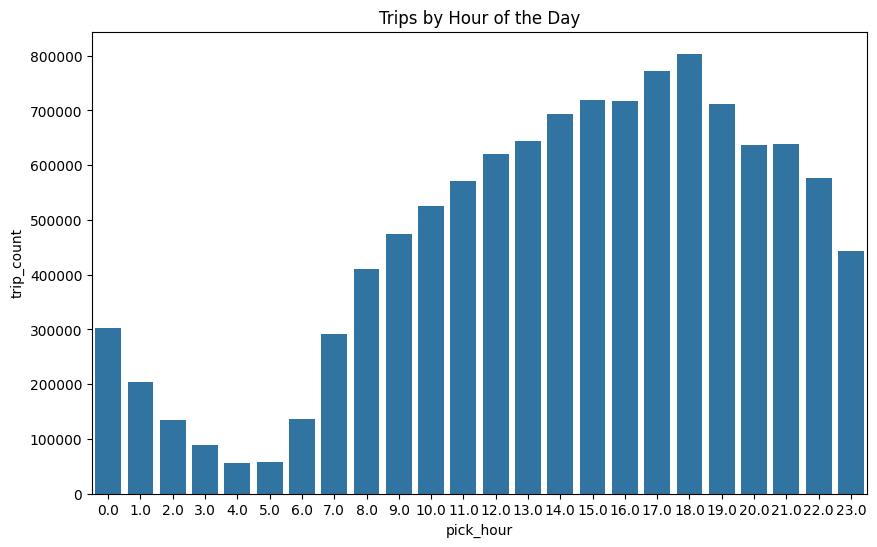

In [19]:
# Trips by Hour of the Day
plt.figure(figsize=(10, 6))
sns.barplot(x="pick_hour", y="trip_count", data=trips_by_hour_pd)
plt.title("Trips by Hour of the Day")
plt.show()

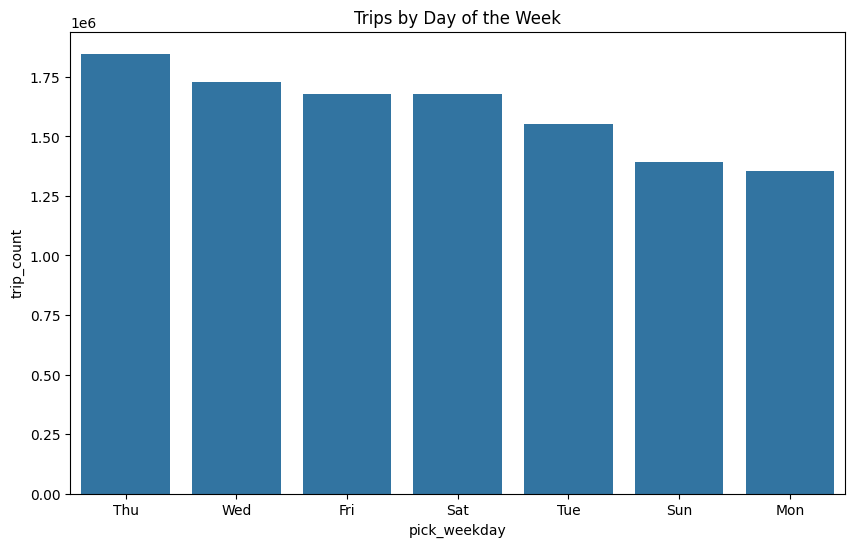

In [20]:
# Trips by Day of the Week
plt.figure(figsize=(10, 6))
sns.barplot(x="pick_weekday", y="trip_count", data=trips_by_day_of_week_pd)
plt.title("Trips by Day of the Week")
plt.show()

In [24]:
total_revenue = analytical_table_df.groupBy().sum("total_amount").toDF("total_revenue")
total_trips = analytical_table_df.groupBy().count().toDF("total_trips")
average_fare = analytical_table_df.groupBy().avg("fare_amount").toDF("average_fare")
trips_by_payment_type = analytical_table_df.groupBy("payment_type_description").count().toDF("payment_type_description", "trip_count")
revenue_by_vendor = analytical_table_df.groupBy("vendor_name").sum("total_amount").toDF("vendor_name", "total_revenue")
trips_by_hour = analytical_table_df.groupBy("pick_hour").count().toDF("pick_hour", "trip_count")
trips_by_day_of_week = analytical_table_df.groupBy("pick_weekday").count().toDF("pick_weekday", "trip_count")

In [26]:
# Convert Spark DataFrames to Pandas DataFrames
total_revenue_pd = total_revenue.toPandas()
total_trips_pd = total_trips.toPandas()
average_fare_pd = average_fare.toPandas()
trips_by_payment_type_pd = trips_by_payment_type.toPandas()
revenue_by_vendor_pd = revenue_by_vendor.toPandas()
trips_by_hour_pd = trips_by_hour.toPandas()
trips_by_day_of_week_pd = trips_by_day_of_week.toPandas()

In [28]:
!pip install openpyxl

   ---------------------------------------- 251.3/251.3 kB 8.4 kB/s eta 0:00:00


In [31]:
# Specify the file path
excel_file_path = "../Processed_Files/4months/KPI's.xlsx"

# Create a Pandas Excel writer using openpyxl as the engine
with pd.ExcelWriter(excel_file_path, engine='openpyxl') as writer:
    # Write each DataFrame to a different sheet
    total_revenue_pd.to_excel(writer, sheet_name='Total Revenue', index=False)
    total_trips_pd.to_excel(writer, sheet_name='Total Trips', index=False)
    average_fare_pd.to_excel(writer, sheet_name='Average Fare', index=False)
    trips_by_payment_type_pd.to_excel(writer, sheet_name='Trips by Payment Type', index=False)
    revenue_by_vendor_pd.to_excel(writer, sheet_name='Revenue by Vendor', index=False)
    trips_by_hour_pd.to_excel(writer, sheet_name='Trips by Hour', index=False)
    trips_by_day_of_week_pd.to_excel(writer, sheet_name='Trips by Day of Week', index=False)

print("Data successfully written to Excel file with multiple sheets.")

Data successfully written to Excel file with multiple sheets.


In [32]:
# Specify the file path
kpi_path = "../Processed_Files/4months/KPI"
total_revenue.write.csv(kpi_path + "total_revenue.csv", header=True)
total_trips.write.csv("kpi_path + potal_trips.csv", header=True)
average_fare.write.csv(kpi_path + "average_fare.csv", header=True)
trips_by_payment_type.write.csv(kpi_path + "trips_by_payment_type.csv", header=True)
revenue_by_vendor.write.csv(kpi_path + "revenue_by_vendor.csv", header=True)
trips_by_hour.write.csv(kpi_path + "trips_by_hour.csv", header=True)
trips_by_day_of_week.write.csv(kpi_path + "trips_by_day_of_week.csv", header=True)

In [33]:
spark.stop()